# Prediction of creditworthiness for credit card issuance

## Step 1: Data Import and Initial Analysis

In this first step, we will:
1. Import the required libraries for data analysis and visualization
2. Load the credit scoring dataset
3. Perform initial data exploration to understand:
   - Dataset dimensions
   - Data types of each column
   - Missing values
   - Basic statistical descriptions
   
This initial analysis will help us understand the data quality and guide our next steps in the data cleaning process.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options and style for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('credit_scoring.csv')

# 1. Dataset Overview and Data Types Summary
print("1. Dataset Overview and Data Types")
print("-" * 50)
print(f"Total records: {df.shape[0]}")
print(f"Total features: {df.shape[1]}\n")

print("Data Types Summary:")
print(df.dtypes.value_counts())
print("\nFeatures by type:")
for dtype in df.dtypes.value_counts().index:
    print(f"\n{dtype}:")
    print(df.select_dtypes(include=[dtype]).columns.tolist())

print("\n2. Features Information")
print("-" * 50)
print(df.info())

# 3. Missing Values Analysis with Percentages
print("\n3. Missing Values Analysis")
print("-" * 50)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_info = pd.DataFrame({
    'Missing Values': missing,
    'Percentage': missing_pct
})
missing_info = missing_info[missing_info['Missing Values'] > 0]
if len(missing_info) > 0:
    print("Features with missing values:")
    print(missing_info)
else:
    print("No missing values found in the dataset")

# 4. Target Variable Distribution
print("\n4. Target Variable Distribution")
print("-" * 50)
target_counts = df['TARGET'].value_counts()
target_pct = df['TARGET'].value_counts(normalize=True).round(4) * 100
print("Class distribution:")
for label, count in target_counts.items():
    print(f"Class {label}: {count} samples ({target_pct[label]:.2f}%)")

# Additional analysis of target distribution by key categorical variables
print("\nTarget Distribution by Key Categories:")
categorical_cols = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
for col in categorical_cols:
    print(f"\n{col} breakdown:")
    cross_tab = pd.crosstab(df[col], df['TARGET'], normalize='index') * 100
    print(cross_tab.round(2))

# 5. Numerical Features Analysis
print("\n5. Key Statistics of Numerical Features")
print("-" * 50)
# Key features statistics
key_features = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
print("Key Features Statistics:")
print(df[key_features].describe().round(2))

# Additional statistics by target
print("\nNumerical Features Statistics by Target Class:")
for feature in key_features:
    print(f"\n{feature} statistics by target:")
    print(df.groupby('TARGET')[feature].describe().round(2))

# 6. Sample Records
print("\n6. First 3 Records Preview")
print("-" * 50)
print(df.head(3))

1. Dataset Overview and Data Types
--------------------------------------------------
Total records: 338427
Total features: 19

Data Types Summary:
object     8
float64    8
int64      3
Name: count, dtype: int64

Features by type:

object:
['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']

float64:
['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']

int64:
['ID', 'CNT_CHILDREN', 'TARGET']

2. Features Information
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338

## Step 2: Data Visualization

In this step, we will:
1. Visualize the distribution of numerical features
2. Examine the relationships between features and the target variable
3. Analyze categorical variables and their impact on the target variable

These visualizations will provide insights into the data, helping us to understand patterns and correlations that may exist.

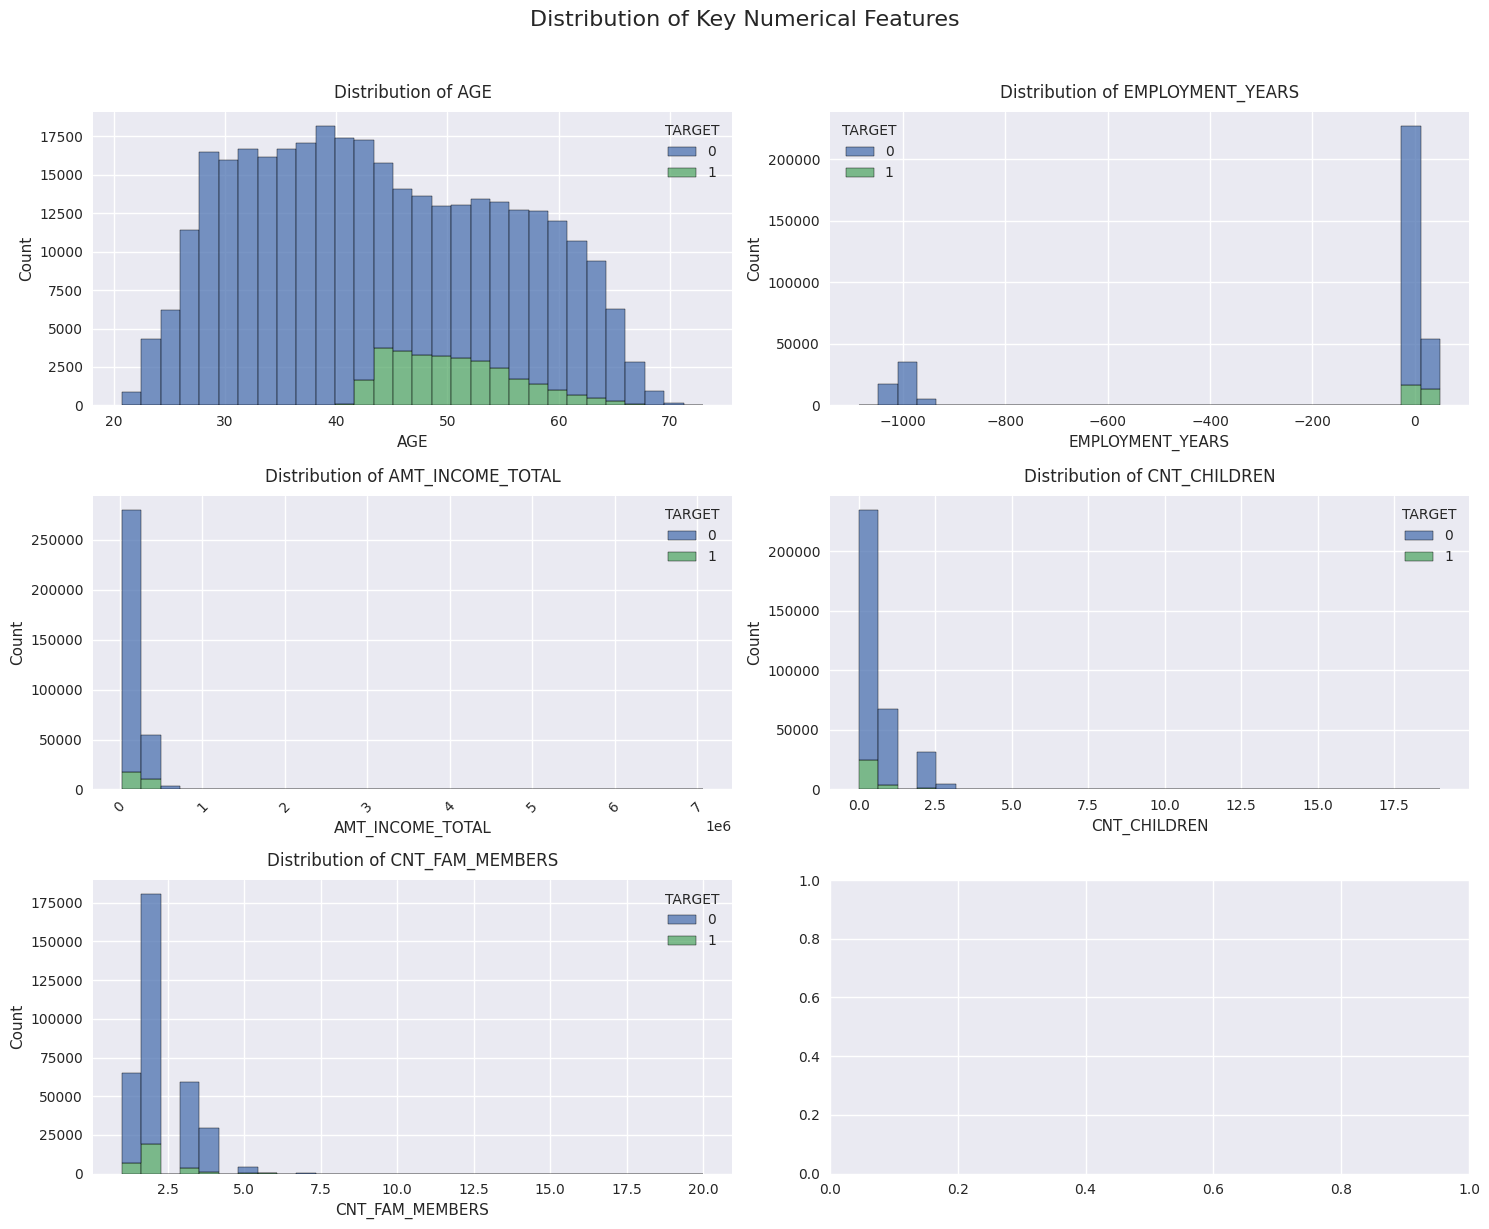

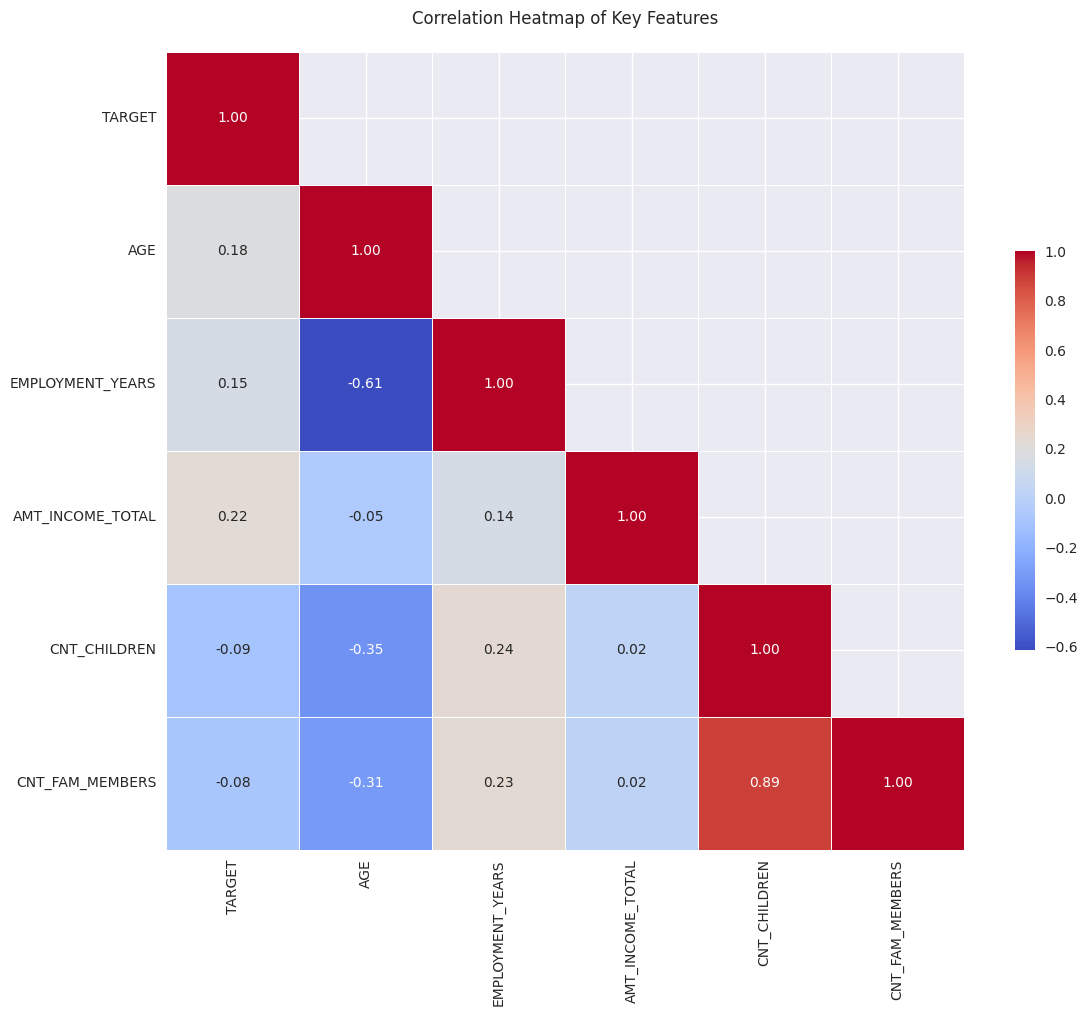

<Figure size 2000x2000 with 0 Axes>

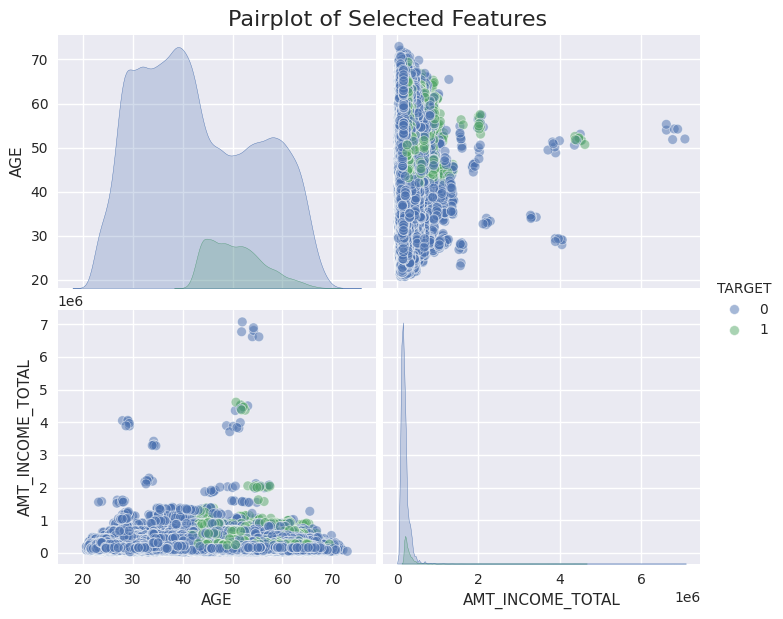

ValueError: keyword ha is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

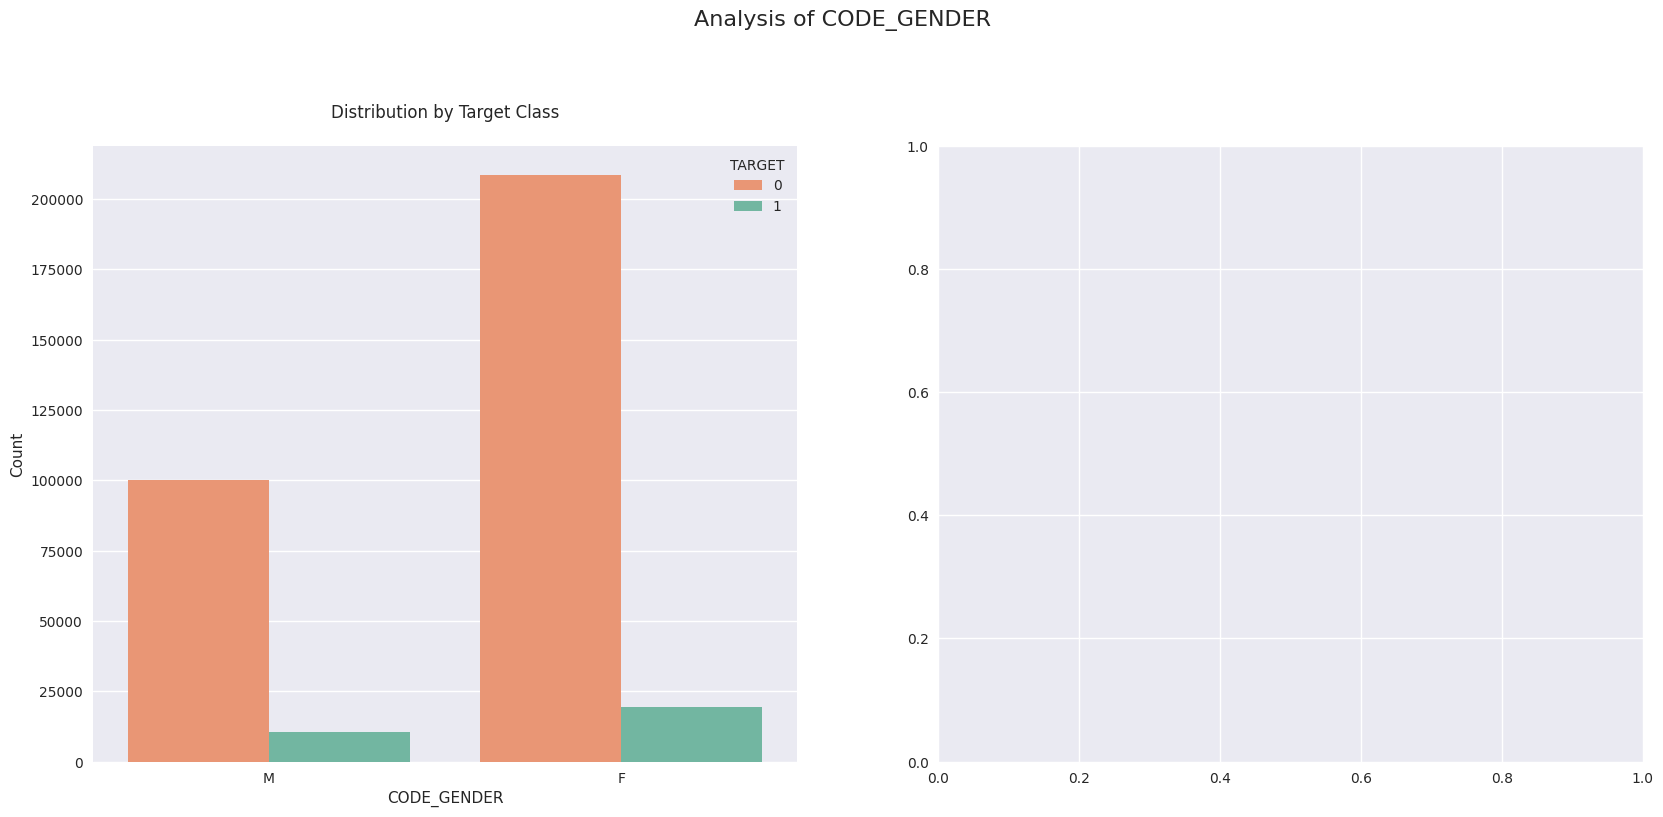

In [ ]:
# 1. Prepare numerical features for visualization
import math
from scipy.stats import chi2_contingency

# Convert DAYS to years for better interpretation
df['AGE'] = -df['DAYS_BIRTH'] / 365
df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365

# Select features to visualize
key_numeric_features = [
    'AGE', 'EMPLOYMENT_YEARS', 'AMT_INCOME_TOTAL', 
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS'
]

# Create subplots with better spacing
n_cols = 2
n_rows = math.ceil(len(key_numeric_features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16, y=1.02)

# Plot distributions with enhanced styling
for idx, feature in enumerate(key_numeric_features):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # Create distribution plot
    sns.histplot(data=df, x=feature, hue='TARGET', multiple="stack", bins=30, ax=ax)
    
    # Customize labels and title
    ax.set_title(f'Distribution of {feature}', pad=10)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    
    # Rotate x-labels if needed
    if feature in ['AMT_INCOME_TOTAL']:
        ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# 2. Correlation heatmap with improved readability
plt.figure(figsize=(12, 10))

# Select relevant features for correlation
relevant_features = [
    'TARGET', 'AGE', 'EMPLOYMENT_YEARS', 'AMT_INCOME_TOTAL', 
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS'
]
correlation_matrix = df[relevant_features].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix), k=1)

# Create heatmap with enhanced styling
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .5},
            annot_kws={"size": 10})

plt.title("Correlation Heatmap of Key Features", pad=20)
plt.tight_layout()
plt.show()

# Pairplot of selected features with larger size
selected_features = [col for col in ['TARGET', 'AGE', 'EMPLOYMENT_LENGTH', 'AMT_INCOME_TOTAL', 'INCOME_PER_PERSON'] if col in df.columns]
if all(col in df.columns for col in selected_features):
    plt.figure(figsize=(20, 20))
    sns.pairplot(df[selected_features], hue='TARGET', diag_kind='kde', 
                plot_kws={'alpha':0.5}, height=3, aspect=1.2)
    plt.suptitle("Pairplot of Selected Features", y=1.02, fontsize=16)
    plt.show()


categorical_vars = [
    'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'
]

for var in categorical_vars:
    # Create figure with more height to accommodate labels
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle(f'Analysis of {var}', fontsize=16, y=1.05)
    
    # Color palette (orange for 0, green for 1)
    target_colors = ['#fc8d62', '#66c2a5']
    
    # Countplot (absolute counts)
    sns.countplot(x=var, hue='TARGET', data=df, ax=axes[0], palette=target_colors)
    axes[0].set_title('Distribution by Target Class', pad=20)
    axes[0].set_xlabel(var)
    axes[0].set_ylabel('Count')
    
    # Rotate labels and align them
    axes[0].tick_params(axis='x', rotation=45)
    for label in axes[0].get_xticklabels():
        label.set_horizontalalignment('right')
    axes[0].legend(title='TARGET', labels=['0', '1'])
    
    # Adjust x-axis labels if they're too long
    if max(len(str(label.get_text())) for label in axes[0].get_xticklabels()) > 15:
        axes[0].tick_params(axis='x', rotation=90)
        for label in axes[0].get_xticklabels():
            label.set_horizontalalignment('right')
    
    # Percentage stacked barplot
    prop_df = (
        df.groupby([var, 'TARGET']).size()
        .unstack(fill_value=0)
        .apply(lambda x: x / x.sum(), axis=1)
    )
    prop_df.plot(kind='bar', stacked=True, ax=axes[1], color=target_colors)
    axes[1].set_title('Proportion of Target Classes', pad=20)
    axes[1].set_xlabel(var)
    axes[1].set_ylabel('Proportion')
    axes[1].legend(title='TARGET', labels=['0', '1'])
    # Rotate labels and align them
    axes[1].tick_params(axis='x', rotation=45)
    for label in axes[1].get_xticklabels():
        label.set_horizontalalignment('right')
    
    # Adjust x-axis labels if they're too long
    if max(len(str(label.get_text())) for label in axes[1].get_xticklabels()) > 15:
        axes[1].tick_params(axis='x', rotation=90)
        for label in axes[1].get_xticklabels():
            label.set_horizontalalignment('right')
    
    # Chi-square test
    contingency = pd.crosstab(df[var], df['TARGET'])
    chi2, p, _, _ = chi2_contingency(contingency)
    
    # Add chi-square test results in a clearer position
    plt.figtext(0.5, -0.05, 
                f'Chi-square test p-value: {p:.2e}', 
                ha='center', 
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Adjust layout with more space for annotations
    plt.subplots_adjust(top=0.85, bottom=0.2)
    plt.show()